In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time

 

In [2]:
DATA_DIR = "./data/"

files = sorted(filter(os.path.isfile, list(os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR))))

print(",".join(files))
images = list(cv2.imread(file) for file in files)
images_grey = list(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images)

./data/01.tif,./data/02.tif,./data/03.tif,./data/04.tif,./data/05.tif,./data/06.tif,./data/07.tif,./data/08.tif,./data/09.tif,./data/10.tif,./data/11.tif,./data/12.tif


In [3]:
class DetectorResults:
    def __init__(self, imgs, mean_time, descriptor_repeat_rate, motion_repeat_rate):
        self.imgs = imgs
        self.time = mean_time
        self.descriptor_repeat_rate = descriptor_repeat_rate
        self.motion_repeat_rate = motion_repeat_rate
        
def get_distance_matrix(a, b):
    return np.sqrt(np.sum((a[:, np.newaxis, :] - b[np.newaxis, :, :]) ** 2, axis = -1))

class BaseDetector:
    def __init__(self, obj, bf):
        self.obj = obj
        self.bf = bf
        
    def __call__(self, imgs_grey):
        t_start = time.perf_counter_ns()
        k_n_desc = [self.obj.detectAndCompute(img, None) for img in imgs_grey]
        
        t_finish = time.perf_counter_ns()

        descriptor_repeat_rate = []
        for i in range(len(imgs_grey)):
            matches_total = 0
            for j in range(len(images)):
                if i == j:
                    continue
                matches = self.bf.match(k_n_desc[i][1], k_n_desc[j][1])
                matches_total += len(matches)
            descriptor_repeat_rate.append(matches_total / len(images) / len(k_n_desc[i][1]))
            
            
        motion_repeat_rate = []
        for i, img in enumerate(imgs_grey):
            matches_total = 0
            for j, img2 in enumerate(imgs_grey):
                if i == j:
                    continue
                (x, y), *_ = cv2.phaseCorrelate(np.float32(img), np.float32(img2))
                kp_base = cv2.KeyPoint_convert(k_n_desc[i][0])
                kp_comp = cv2.KeyPoint_convert(k_n_desc[j][0])
                kp_comp[:, 0] -= x
                kp_comp[:, 1] -= y
            
                distances = get_distance_matrix(kp_base, kp_comp).min(axis=1)
                matches_total += np.sum(distances < 2.5)
            
            motion_repeat_rate.append(matches_total / len(images) / len(k_n_desc[i][0]))
        return DetectorResults(imgs=imgs_grey, 
                               mean_time=(t_finish-t_start) / sum(len(x[0]) for x in k_n_desc),
                               descriptor_repeat_rate=descriptor_repeat_rate,
                               motion_repeat_rate=motion_repeat_rate
                              )
        
class ShiTomasiDetectAndCompute(BaseDetector):
    def __init__(self):
        self.sift = cv2.SIFT_create()
    
    def detectAndCompute(self, img, _):
        corn = cv2.goodFeaturesToTrack(img,20,0.001,2)
        kp = [cv2.KeyPoint(x=f[0][0], y=f[0][1], size=20) for f in corn]
        
        return self.sift.compute(img,kp)
        
class ShiTomasiDetector(BaseDetector):
    def __init__(self):
        super().__init__(ShiTomasiDetectAndCompute(), cv2.BFMatcher(cv2.NORM_L2, crossCheck=True))
        
    def name(self):
        return "Shi-Tomasi(with SIFT descriptors)"

class OrbDetector(BaseDetector):
    def __init__(self):
        super().__init__(cv2.ORB_create(), cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True))

    def name(self):
        return "ORB"
        
class SiftDetector(BaseDetector):
    def __init__(self):
        super().__init__(cv2.SIFT_create(), cv2.BFMatcher(cv2.NORM_L2, crossCheck=True))
        
    def name(self):
        return "SIFT"
    
    
class BriskDetector(BaseDetector):
    def __init__(self):
        super().__init__(cv2.BRISK_create(), cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True))
        
    def name(self):
        return "BRISK"

In [4]:
results = dict()

for detector in (ShiTomasiDetector(), OrbDetector(), SiftDetector(), BriskDetector()):
    result = detector(images_grey)
    
    results[detector.name()] = result

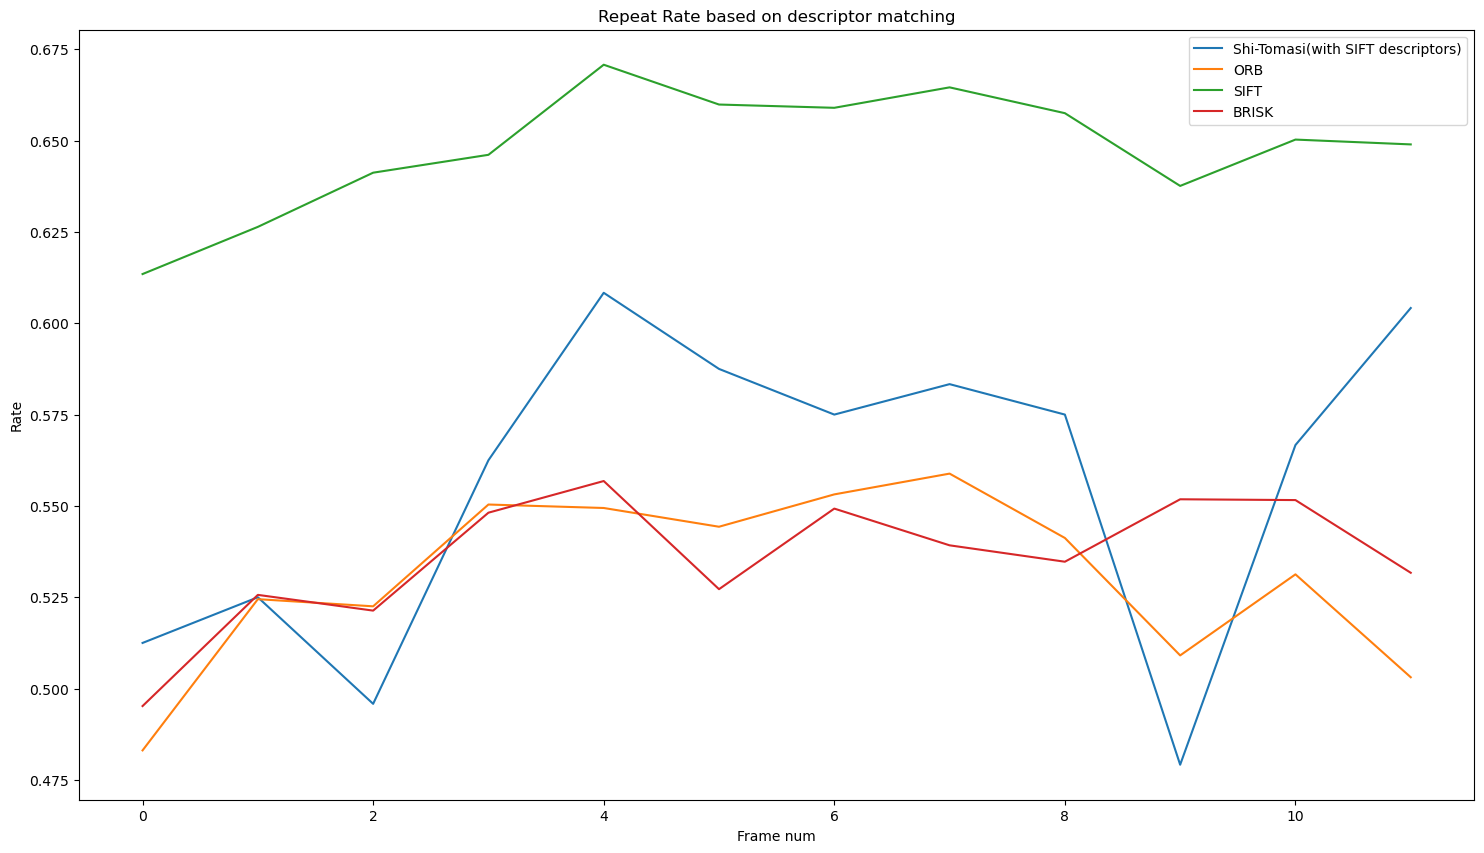

In [5]:
plt.figure(figsize=(18, 10))


for name, detector_result in results.items():
    plt.plot(detector_result.descriptor_repeat_rate, label=name)
    
plt.legend()
plt.xlabel("Frame num")
plt.ylabel("Rate")
plt.title("Repeat Rate based on descriptor matching")
plt.show()

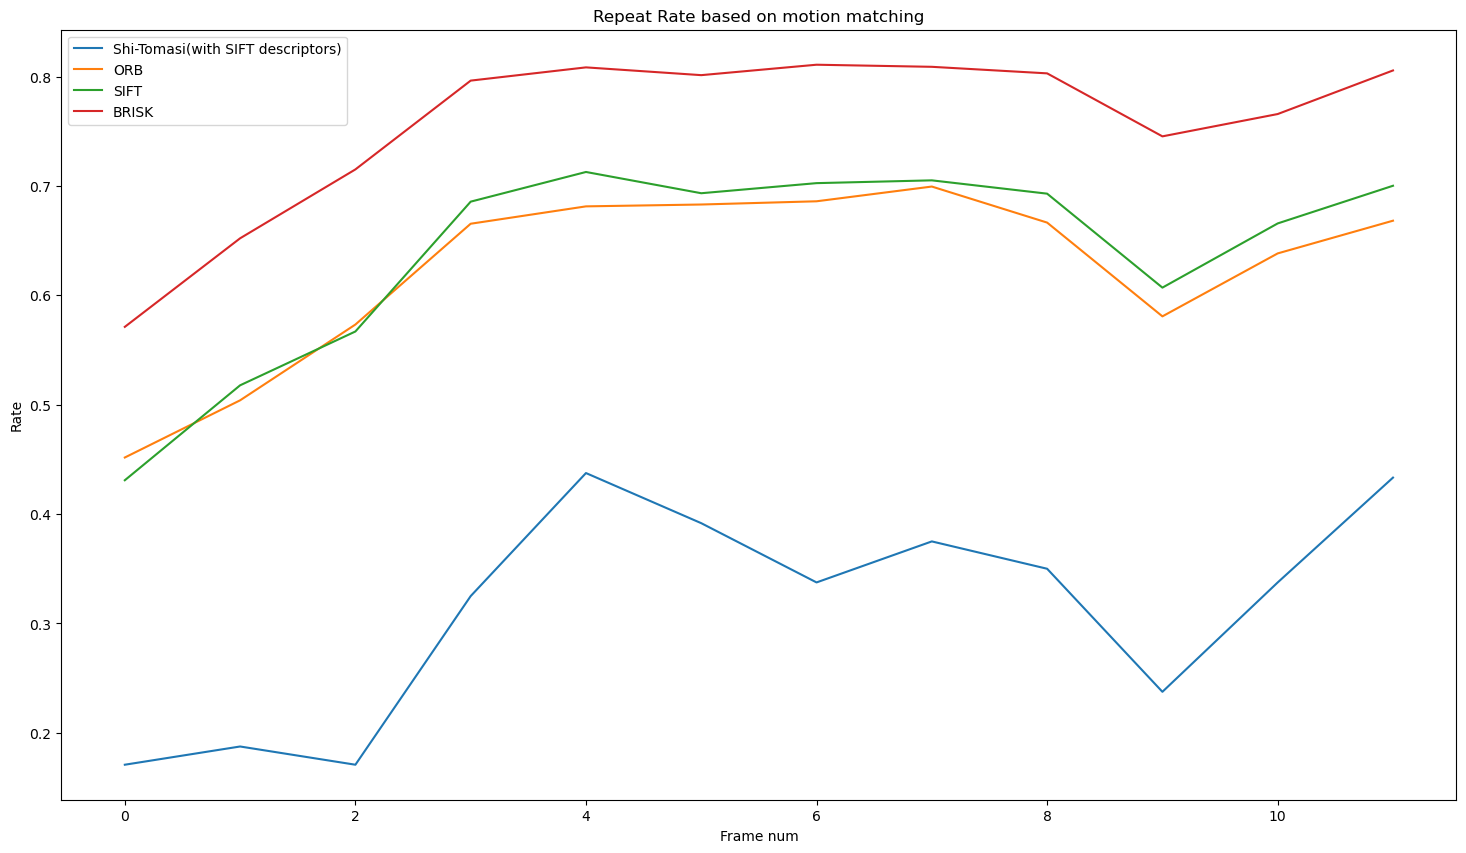

In [6]:
plt.figure(figsize=(18, 10))


for name, detector_result in results.items():
    plt.plot(detector_result.motion_repeat_rate, label=name)
    
plt.legend()
plt.xlabel("Frame num")
plt.ylabel("Rate")
plt.title("Repeat Rate based on motion matching")
plt.show()

In [7]:
for name, detector_result in results.items():
    print("detector: {: <40} mean time (per point): \t{:.5f}ms".format(name, detector_result.time / 1e6))

detector: Shi-Tomasi(with SIFT descriptors)        mean time (per point): 	0.30020ms
detector: ORB                                      mean time (per point): 	0.00616ms
detector: SIFT                                     mean time (per point): 	0.03939ms
detector: BRISK                                    mean time (per point): 	0.01717ms
